In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
from torchvision.datasets import DatasetFolder
import torchvision
from tqdm.notebook import tqdm as tqdm
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from sklearn.metrics import f1_score
import torch.nn.functional as F

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.')
else:
    print('CUDA is available!')
device = "cuda" if train_on_gpu else "cpu"

CUDA is available!


In [3]:
train_image_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/train/"
val_image_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/validation/"
test_image_path = "/home/max/Desktop/galaxy_science_display/galaxy_image/eight_type/test/"

In [4]:
batch_size = 16
train_trans = transforms.Compose([
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomRotation((-30, 30)),
                                  transforms.Resize((255, 255)),
#                                   transforms.CenterCrop(210),
#                                   transforms.Resize((255, 255)),
#                                   transforms.GaussianBlur(7,3),
#                                   transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
#                                   transforms.RandomCrop(size=(255, 255)),
                                  transforms.ToTensor()])

train_data = ImageFolder(train_image_path, transform = train_trans)
train_loader = DataLoader(train_data, pin_memory = True, batch_size = batch_size, sampler=ImbalancedDatasetSampler(train_data))

val_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
val_data = ImageFolder(val_image_path, transform = val_trans)
val_loader = DataLoader(val_data, shuffle = True)

test_trans = transforms.Compose([transforms.Resize((255, 255)),transforms.ToTensor()])
test_data = ImageFolder(test_image_path, transform = test_trans)
test_loader = DataLoader(test_data, shuffle = True)

print('Train:', len(train_data))
print('Valid:', len(val_data))
print('Test:', len(test_data))

Train: 1923
Valid: 145
Test: 145


tensor([0, 0, 1, 3, 4, 0, 3, 1, 7, 2, 3, 7, 1, 3, 0, 7])
tensor(0)


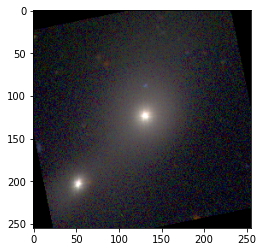

tensor(0)


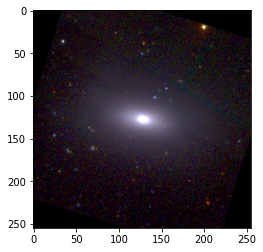

tensor(1)


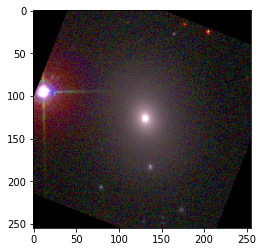

In [5]:
images, labels = next(iter(train_loader))
print(labels)
for i in np.arange(3):
    print(labels[i])
    plt.figure(i)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()

In [6]:
# 1. Input layer
# 2. Convolutional layer
# 3. ReLU layer
# 4. Pooling layer
# 5. Fully-connected layer
class Galaxy(nn.Module):
  def __init__(self):
    super(Galaxy, self).__init__()
    # input_shape = (3, 224, 224)
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, 
    #                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    # in_channels: Input channels
    # out_channels: Output channels
    # kernel_size: Fillter size
    # stride: Each step our Fillter move
    # padding: We want our image can remain origin size
    self.cnn = nn.Sequential(
        ## CNN1
        nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1), # padding = kernel_size / 2
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (64, 112, 112)
        ## CNN2
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (128, 56, 56)
        ## CNN3
        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (256, 28, 28)
        ## CNN4
        nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2),## (512, 14, 14)
        ## CNN5
        nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2)## (512, 7, 7)
        ## CNN6
#         nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 1, padding = 1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size = 2)## (1024, 3, 3)
    )
    self.fc = nn.Sequential(
        nn.Linear(512 * 7 * 7, 512), # Fully-connected layer
        nn.Dropout(0.1), # Avoid overfitting
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.Dropout(0.1),
        nn.ReLU(),
#         nn.Linear(512, 256),
#         nn.Dropout(0.5),
#         nn.ReLU(),
        nn.Linear(128, 3)
    )
  # forward propagation
  def forward(self, x):
    x = self.cnn(x)
    x = x.flatten(1)
    x = self.fc(x)
    return x

In [7]:
class VGG16(nn.Module):

    def __init__(self, num_classes):
        super(VGG16, self).__init__()

        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      # (1(32-1)- 32 + 3)/2 = 1
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,
                      out_channels=512,
                      kernel_size=(3, 3),
                      stride=(1, 1),
                      padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2),
                         stride=(2, 2))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.65),
            nn.Linear(4096, 1000),
        )

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
#                 nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    m.bias.detach().zero_()

        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        # x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
#         probas = F.softmax(logits, dim=1)
        # probas = nn.Softmax(logits)
#         return probas
        return logits

In [8]:
model2 = VGG16(8)
model2 = model2.to(device)

In [9]:
summary(model2, (3, 255, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 255, 255]           1,792
       BatchNorm2d-2         [-1, 64, 255, 255]             128
              ReLU-3         [-1, 64, 255, 255]               0
            Conv2d-4         [-1, 64, 255, 255]          36,928
       BatchNorm2d-5         [-1, 64, 255, 255]             128
              ReLU-6         [-1, 64, 255, 255]               0
         MaxPool2d-7         [-1, 64, 127, 127]               0
            Conv2d-8        [-1, 128, 127, 127]          73,856
       BatchNorm2d-9        [-1, 128, 127, 127]             256
             ReLU-10        [-1, 128, 127, 127]               0
           Conv2d-11        [-1, 128, 127, 127]         147,584
      BatchNorm2d-12        [-1, 128, 127, 127]             256
             ReLU-13        [-1, 128, 127, 127]               0
        MaxPool2d-14          [-1, 128,

/home/max/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
# model = Galaxy()
model = torchvision.models.vgg16(pretrained=False)
# model = torchvision.models.resnet18(pretrained=False)
model = model.to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
summary(model, (3, 255, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 255, 255]           1,792
              ReLU-2         [-1, 64, 255, 255]               0
            Conv2d-3         [-1, 64, 255, 255]          36,928
              ReLU-4         [-1, 64, 255, 255]               0
         MaxPool2d-5         [-1, 64, 127, 127]               0
            Conv2d-6        [-1, 128, 127, 127]          73,856
              ReLU-7        [-1, 128, 127, 127]               0
            Conv2d-8        [-1, 128, 127, 127]         147,584
              ReLU-9        [-1, 128, 127, 127]               0
        MaxPool2d-10          [-1, 128, 63, 63]               0
           Conv2d-11          [-1, 256, 63, 63]         295,168
             ReLU-12          [-1, 256, 63, 63]               0
           Conv2d-13          [-1, 256, 63, 63]         590,080
             ReLU-14          [-1, 256,

In [12]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0015)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.01)
loss_func = nn.CrossEntropyLoss()
# # reg = JacobianReg() # Jacobian regularization
# lambda_JR = 0.01 # hyperparameter
l1_crit = nn.L1Loss(size_average=False)
factor = 0.03
n_epochs = 50
train_loss_record = []
train_acc_record = []
val_loss_record = []
val_acc_record = []
min_loss = 2000.
for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    val_acc = 0.0
    model.train()
    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        prediction = model(x)
#         reg_loss = 0
#         reg_loss = l1_crit(prediction.argmax(dim = 1), y)
#         print
        loss = loss_func(prediction, y)
        
#         loss = super_loss + factor*reg_loss
        
        loss.backward()
        optimizer.step()
        
        acc = ((prediction.argmax(dim = 1) == y).float().mean())
        train_acc += acc/len(train_loader)
        train_loss += loss/len(train_loader)
    print(f"[ Train | {epoch+1}/{n_epochs} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    train_loss_record.append(train_loss.item())
    train_acc_record.append(train_acc.item())

    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x, y = x.to(device), y.to(device)
            prediction = model(x)
    #         reg_loss = 0

    #         reg_loss = l1_crit(prediction.argmax(dim = 1), y)

            loss = loss_func(prediction, y)

    #         loss = super_loss + factor*reg_loss

    #         loss.backward()
            acc = ((prediction.argmax(dim = 1) == y).float().mean())
            val_acc += acc/len(val_loader)
            val_loss += loss/len(val_loader)
            if loss < min_loss:
                min_loss = loss
                torch.save(model, 'E_I_S_new_1227.pkl')
        print(f"[ Validation | {epoch+1}/{n_epochs} ] loss = {val_loss:.5f}, acc = {val_acc:.5f}")
        val_loss_record.append(val_loss.item())
        val_acc_record.append(val_acc.item())
# torch.save(model, 'E_I_Sc.pkl')

/home/max/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 1/50 ] loss = 2.47835, acc = 0.12001


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 1/50 ] loss = 2.14595, acc = 0.13793


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 2/50 ] loss = 2.17616, acc = 0.13017


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 2/50 ] loss = 2.09455, acc = 0.13793


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 3/50 ] loss = 2.10232, acc = 0.15857


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 3/50 ] loss = 1.76961, acc = 0.28276


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 4/50 ] loss = 1.93796, acc = 0.21798


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 4/50 ] loss = 1.94137, acc = 0.22759


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 5/50 ] loss = 1.82924, acc = 0.26636


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 5/50 ] loss = 1.54750, acc = 0.39310


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 6/50 ] loss = 1.69620, acc = 0.30441


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 6/50 ] loss = 1.56552, acc = 0.33103


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 7/50 ] loss = 1.61812, acc = 0.31990


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 7/50 ] loss = 1.56557, acc = 0.31034


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 8/50 ] loss = 1.55852, acc = 0.34470


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 8/50 ] loss = 1.45576, acc = 0.35172


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 9/50 ] loss = 1.53505, acc = 0.34470


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 9/50 ] loss = 1.51391, acc = 0.36552


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 10/50 ] loss = 1.53331, acc = 0.34625


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 10/50 ] loss = 1.52173, acc = 0.41379


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 11/50 ] loss = 1.55283, acc = 0.34246


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 11/50 ] loss = 1.37381, acc = 0.39310


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 12/50 ] loss = 1.46312, acc = 0.36467


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 12/50 ] loss = 1.41880, acc = 0.35862


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 13/50 ] loss = 1.49871, acc = 0.37345


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 13/50 ] loss = 1.34489, acc = 0.37241


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 14/50 ] loss = 1.48999, acc = 0.36915


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 14/50 ] loss = 1.55276, acc = 0.35172


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 15/50 ] loss = 1.44905, acc = 0.39050


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 15/50 ] loss = 1.38381, acc = 0.40000


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 16/50 ] loss = 1.47254, acc = 0.37466


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 16/50 ] loss = 1.37502, acc = 0.40000


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 17/50 ] loss = 1.40923, acc = 0.40737


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 17/50 ] loss = 1.45157, acc = 0.37931


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 18/50 ] loss = 1.38578, acc = 0.40978


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 18/50 ] loss = 1.37458, acc = 0.44138


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 19/50 ] loss = 1.36414, acc = 0.42837


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 19/50 ] loss = 1.32588, acc = 0.43448


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 20/50 ] loss = 1.34023, acc = 0.42820


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 20/50 ] loss = 1.32205, acc = 0.37931


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 21/50 ] loss = 1.36914, acc = 0.40909


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 21/50 ] loss = 1.41966, acc = 0.33793


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 22/50 ] loss = 1.37439, acc = 0.43457


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 22/50 ] loss = 1.33803, acc = 0.48276


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 23/50 ] loss = 1.35044, acc = 0.45093


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 23/50 ] loss = 1.46191, acc = 0.38621


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 24/50 ] loss = 1.32718, acc = 0.46970


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 24/50 ] loss = 1.66472, acc = 0.35862


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 25/50 ] loss = 1.34914, acc = 0.45610


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 25/50 ] loss = 1.29727, acc = 0.44828


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 26/50 ] loss = 1.31548, acc = 0.44594


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 26/50 ] loss = 1.33080, acc = 0.46207


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 27/50 ] loss = 1.27092, acc = 0.47056


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 27/50 ] loss = 1.44583, acc = 0.42069


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 28/50 ] loss = 1.30425, acc = 0.46556


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 28/50 ] loss = 1.33310, acc = 0.49655


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 29/50 ] loss = 1.25881, acc = 0.49587


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 29/50 ] loss = 1.29584, acc = 0.47586


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 30/50 ] loss = 1.28649, acc = 0.46918


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 30/50 ] loss = 1.35575, acc = 0.46897


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 31/50 ] loss = 1.23408, acc = 0.50981


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 31/50 ] loss = 1.29838, acc = 0.44138


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 32/50 ] loss = 1.23334, acc = 0.50189


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 32/50 ] loss = 1.39638, acc = 0.46207


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 33/50 ] loss = 1.24844, acc = 0.47899


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 33/50 ] loss = 1.31236, acc = 0.50345


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 34/50 ] loss = 1.22604, acc = 0.48795


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 34/50 ] loss = 1.37315, acc = 0.47586


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 35/50 ] loss = 1.22114, acc = 0.51050


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 35/50 ] loss = 1.29140, acc = 0.50345


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 36/50 ] loss = 1.24602, acc = 0.50465


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 36/50 ] loss = 1.29557, acc = 0.47586


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 37/50 ] loss = 1.19164, acc = 0.52238


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 37/50 ] loss = 1.24009, acc = 0.47586


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 38/50 ] loss = 1.15273, acc = 0.52600


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 38/50 ] loss = 1.27570, acc = 0.47586


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 39/50 ] loss = 1.15481, acc = 0.52755


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 39/50 ] loss = 1.24002, acc = 0.46207


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 40/50 ] loss = 1.16610, acc = 0.52445


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 40/50 ] loss = 1.20782, acc = 0.48966


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 41/50 ] loss = 1.12868, acc = 0.55234


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 41/50 ] loss = 1.17618, acc = 0.48966


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 42/50 ] loss = 1.10867, acc = 0.55148


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 42/50 ] loss = 1.24832, acc = 0.46897


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 43/50 ] loss = 1.11154, acc = 0.54632


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 43/50 ] loss = 1.22175, acc = 0.48276


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 44/50 ] loss = 1.11239, acc = 0.54459


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 44/50 ] loss = 1.25815, acc = 0.49655


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 45/50 ] loss = 1.07440, acc = 0.57868


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 45/50 ] loss = 1.34166, acc = 0.51035


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 46/50 ] loss = 1.05419, acc = 0.59074


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 46/50 ] loss = 1.36590, acc = 0.48966


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 47/50 ] loss = 1.06062, acc = 0.58127


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 47/50 ] loss = 1.25369, acc = 0.49655


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 48/50 ] loss = 1.03824, acc = 0.59539


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 48/50 ] loss = 1.28442, acc = 0.54483


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 49/50 ] loss = 1.00852, acc = 0.60176


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 49/50 ] loss = 1.17828, acc = 0.54483


  0%|          | 0/121 [00:00<?, ?it/s]

[ Train | 50/50 ] loss = 1.01101, acc = 0.60107


  0%|          | 0/145 [00:00<?, ?it/s]

[ Validation | 50/50 ] loss = 1.21832, acc = 0.51035


In [14]:
!nvidia-smi

Mon Dec 27 13:37:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 32%   59C    P2   178W / 200W |   7862MiB /  7973MiB |     52%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
actu = []
ai_pred = []
model.eval()
test_acc = 0.0
test_loss = 0.0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    prediction = model(x)
    actu.append(y.to('cpu').numpy()[0])
    ai_pred.append(prediction.argmax().to('cpu').numpy().tolist())
    loss = loss_func(prediction, y)
    loss.backward()
    acc = ((prediction.argmax(dim = 1) == y).float().mean())
    test_acc += acc/len(test_loader)
    test_loss += loss/len(test_loader)
print(f"[ Test ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

[ Test ] loss = 1.32639, acc = 0.48276


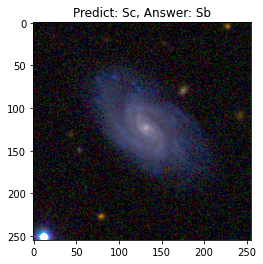

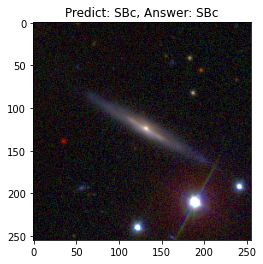

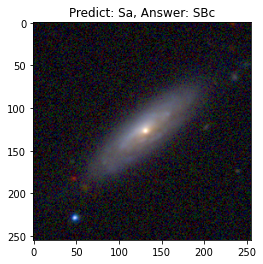

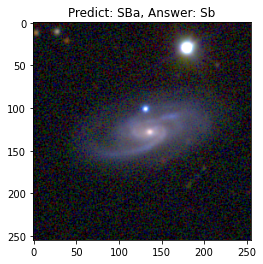

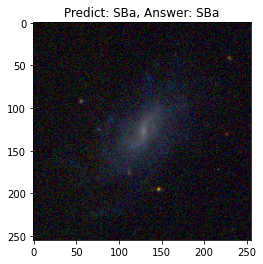

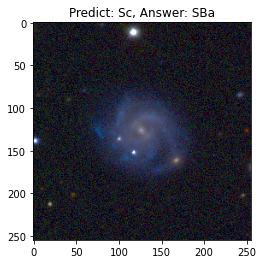

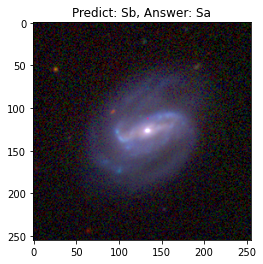

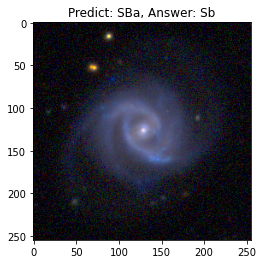

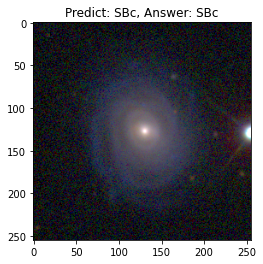

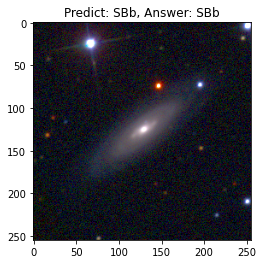

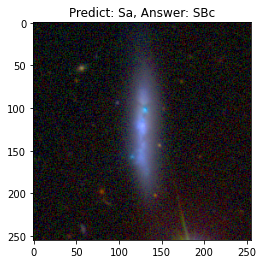

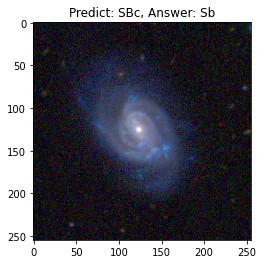

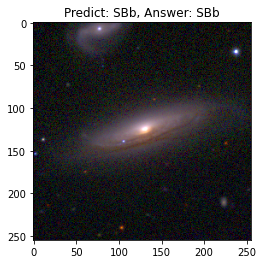

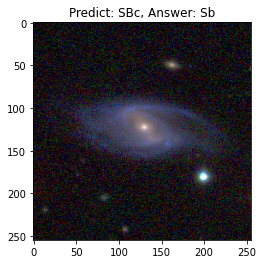

In [16]:
model = torch.load('E_I_S_new_1227.pkl')
galaxy_type = ['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc']
loss_func = nn.CrossEntropyLoss()
i = 0
for x, y in val_loader:
    i += 1
    if train_on_gpu:
        x, y = x.cuda(), y.cuda()
    output = model(x)
    out = output.argmax(dim = 1)
    out = out.to('cpu').numpy()
    ans = galaxy_type[y[0]]
    pre = galaxy_type[out[0]]
    if i % 10 == 0:
        
        plt.figure(i)
        plt.title(f'Predict: {pre}, Answer: {ans}')
#         if out[0] == 0:
            
#         elif out[0] == 1:
#             plt.title(f'Predict: {pre}, Answer: {ans}')
#         else:
#             plt.title(f'Predict: S, Answer: {ans}')
        x = x.squeeze()
        x = x.to('cpu')
        plt.imshow(x.permute(1, 2, 0))
        plt.show()

In [17]:
print(val_acc_record)

[0.13793106377124786, 0.13793106377124786, 0.2827587127685547, 0.2275862842798233, 0.39310359954833984, 0.3310346007347107, 0.310344934463501, 0.3517242670059204, 0.36551737785339355, 0.41379326581954956, 0.39310359954833984, 0.358620822429657, 0.3724139332771301, 0.3517242670059204, 0.4000001549720764, 0.4000001549720764, 0.3793104887008667, 0.44137948751449585, 0.4344829320907593, 0.3793104887008667, 0.33793115615844727, 0.4827588200569153, 0.38620704412460327, 0.358620822429657, 0.4482760429382324, 0.46206915378570557, 0.42068982124328613, 0.4965519309043884, 0.4758622646331787, 0.46896570920944214, 0.44137948751449585, 0.46206915378570557, 0.503448486328125, 0.4758622646331787, 0.503448486328125, 0.4758622646331787, 0.4758622646331787, 0.4758622646331787, 0.46206915378570557, 0.48965537548065186, 0.48965537548065186, 0.46896570920944214, 0.4827588200569153, 0.4965519309043884, 0.5103450417518616, 0.48965537548065186, 0.4965519309043884, 0.5448278188705444, 0.5448278188705444, 0.510

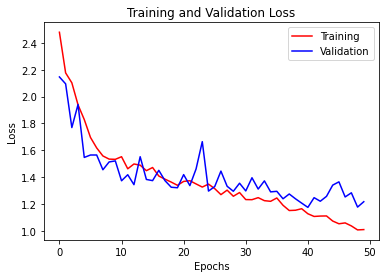

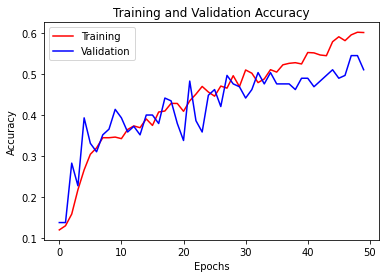

In [18]:
plt.figure(1)
plt.title('Training and Validation Loss')
train_l, = plt.plot(train_loss_record, color = 'red')
val_l, = plt.plot(val_loss_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(handles = [train_l, val_l], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

plt.figure(2)
plt.title('Training and Validation Accuracy')
train_a, = plt.plot(train_acc_record, color = 'red')
val_a, = plt.plot(val_acc_record, color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(handles = [train_a, val_a], labels = ['Training', 'Validation'], loc = 'best')
plt.show()

In [19]:
confmat = confusion_matrix(y_true=actu, y_pred=ai_pred)

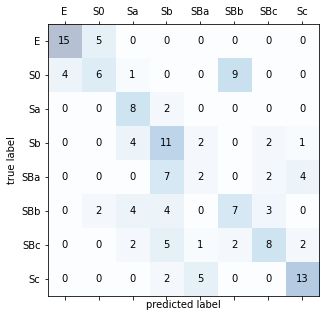

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],['E', 'S0', 'Sa', 'Sb', 'SBa', 'SBb', 'SBc', 'Sc'])
plt.show()

In [21]:
f1score = f1_score(actu, ai_pred, average='weighted')
print(f1score)

0.4738849187071302
